In [1]:
from skimage.io import imread
from skimage import morphology, measure
import os, glob, tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', size=15)
rc('font', family='Arial')
# rc('font', serif='Times')
rc('pdf', fonttype=42)
# rc('text', usetex=True)


First, define the experiment folder (it depends on whether you are using local machine or server workstation).
So far, the analysis can be run on a single well of a single ibidi slide at a time. In this case we chose 'coated-wt-triton'

In [5]:
pc = os.environ['COMPUTERNAME']
if pc=='PCBA-TRIVEDI03': # my Razer
    folder_raw = os.path.join('E:',os.sep,'immuno_NMG')
elif pc=='PCBA-TRIVEDI02': # workstation
    folder_raw = os.path.join('Y:',os.sep,'Nicola_Gritti','raw_data','immuno_NMG')

exp_folder = os.path.join('2021-02-14_NMG_immuno2_fullSlide2')

resultFolder = os.path.join(folder_raw, exp_folder, 'results')

down=1
imgName = 'clide2_var653-stitched_%d%d.tif'%(down,down)

Next, define which channels are available in the images and the color you want to have them displayed with.
In this case, the membrane marker is not present because we remove it at stitching stage...

In [6]:
channels = ['Bright field','DAPI','Trim28','Sepdb1']#,'Membrane']
colors = ['black','blue','green','orange']#,'maroon']

Read in the csv file containing the properties of the cells from the StarDist segmentation and skimage-measureprops function (that is, from the previous script).
Also, load the full image and the mask generated by the segmentation

In [7]:
# load cell props
print('Loading cell props...')
props = pd.read_csv(os.path.join(resultFolder,'props_'+os.path.splitext(imgName)[0]+'.csv'))
nch = len([i for i in props.keys() if 'mean_intens' in i])
print('Done. Found %d cells with %d features'%(len(props.label), len(props.keys())))

# load image
print('Loading image...')
X = imread(os.path.join(resultFolder,imgName))
print('Done.',X.shape)

# load image
print('Loading mask...')
maskName = 'mask_'+imgName
Y = imread(os.path.join(resultFolder,maskName))
print('Done.',Y.shape)


Loading cell props...
Done. Found 27037 cells with 26 features
Loading image...
Done. (16720, 16720, 4)
Loading mask...
Done. (16720, 16720)


In [8]:
props.head()

,Unnamed: 0,fileName,label,bbox-0,bbox-1,bbox-2,bbox-3,centroid-0,centroid-1,area,...,mean_intensity-2,mean_intensity-3,min_intensity-0,min_intensity-1,min_intensity-2,min_intensity-3,max_intensity-0,max_intensity-1,max_intensity-2,max_intensity-3
0,0,rep1_WT-stitched_11.tif,1,0,244,33,314,13.212974,275.300230,1742,...,125.804248,131.324914,1894,209,105,98,2384,841,149,164
1,1,rep1_WT-stitched_11.tif,2,0,666,52,726,22.457165,694.693925,2568,...,137.521417,143.621495,1923,309,112,103,2383,1688,169,280
2,2,rep1_WT-stitched_11.tif,3,0,914,47,987,20.355216,948.511356,2818,...,131.619588,139.968062,1814,259,107,110,2386,916,158,191
3,3,rep1_WT-stitched_11.tif,4,0,1069,66,1133,32.123835,1099.861437,3327,...,139.533514,143.977157,1594,273,112,107,2458,1337,175,191
4,4,rep1_WT-stitched_11.tif,5,0,2010,42,2048,18.883185,2028.222470,1344,...,127.055060,126.014137,1862,296,108,99,2361,970,153,153


In [9]:
print(props.keys())
print('Cells:', len(props.label))

Index(['Unnamed: 0', 'fileName', 'label', 'bbox-0', 'bbox-1', 'bbox-2',
       'bbox-3', 'centroid-0', 'centroid-1', 'area', 'perimeter',
       'minor_axis_length', 'major_axis_length', 'eccentricity',
       'mean_intensity-0', 'mean_intensity-1', 'mean_intensity-2',
       'mean_intensity-3', 'min_intensity-0', 'min_intensity-1',
       'min_intensity-2', 'min_intensity-3', 'max_intensity-0',
       'max_intensity-1', 'max_intensity-2', 'max_intensity-3'],
      dtype='object')
Cells: 27037


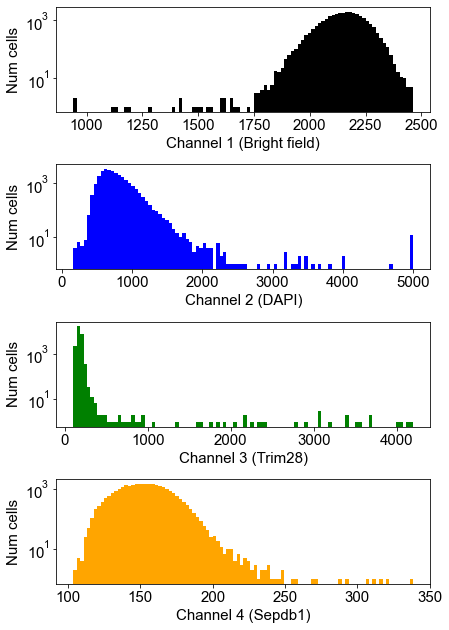

In [10]:
# plot of distributions
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(6,9))
fig.subplots_adjust(top=0.99, hspace=0.5, bottom=0.1, right=0.99)
for i in range(nch):
    data = props['mean_intensity-%d'%i]
    data = np.clip(data,0,5000)
    ax[i].hist(data, bins=100, color=colors[i])
    ax[i].set_xlabel('Channel %d (%s)'%(i+1,channels[i]))
    ax[i].set_ylabel('Num cells')
    ax[i].set_yscale('log')
plt.show()

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_histogram.png'),dpi=300)

Transfected cells: 45
Not transfected cells: 26992


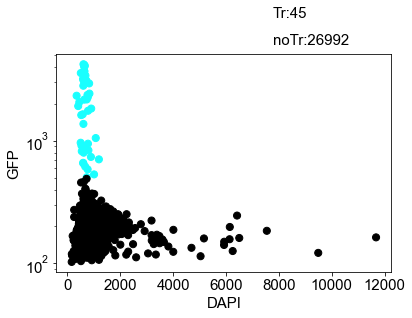

In [11]:
# determine cutoff to define cells that were successfully transfected
# use the gfp channel to determine threshold.
gfp = props['mean_intensity-%d'%2].values
dapi = props['mean_intensity-%d'%1].values

# Assume bimodal distribution (negative cells + positive cells) and use KMeans clustering with 2 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)

# cluster the data points
kmeans.fit(gfp.reshape(-1,1))
y_kmeans = kmeans.predict(gfp.reshape(-1,1))

# custom threshold
y_kmeans = (gfp>500)&(gfp<10000)

# visualize
from matplotlib.colors import LinearSegmentedColormap
colors = [(0.0, 0.0, 0.0), (0,0,.5), (.2, .2, 1.), (.1,1.,1.)] # Experiment with this
cm = LinearSegmentedColormap.from_list('test', colors, N=255)

fig, ax = plt.subplots()
ax.scatter(dapi, gfp, c=y_kmeans, s=50, cmap=cm)
plt.yscale('log')
ax.set_xlabel('DAPI')
ax.set_ylabel('GFP')

# assign cluster to cells
props['transfected'] = y_kmeans.astype(bool)
ax.text(np.max(props['mean_intensity-1'])*2/3,10000,'Tr:'+str(len(props[props.transfected])))
ax.text(np.max(props['mean_intensity-1'])*2/3,6000,'noTr:'+str(len(props[props.transfected==False])))

print('Transfected cells:', len(props[props.transfected]))
print('Not transfected cells:', len(props[props.transfected==False]))

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_transfected.png'),dpi=300)

In [12]:
transfected = props[props.transfected]
transfected.head()

,Unnamed: 0,fileName,label,bbox-0,bbox-1,bbox-2,bbox-3,centroid-0,centroid-1,area,...,mean_intensity-3,min_intensity-0,min_intensity-1,min_intensity-2,min_intensity-3,max_intensity-0,max_intensity-1,max_intensity-2,max_intensity-3,transfected
965,965,rep1_WT-stitched_11.tif,966,608,12232,647,12274,627.738673,12252.947411,1236,...,156.968447,1035,264,244,119,2555,893,998,218,True
2175,2175,rep1_WT-stitched_11.tif,2176,1331,10042,1373,10088,1351.662791,10064.894703,1548,...,165.718992,1701,283,1120,117,2700,955,5932,213,True
2557,2557,rep1_WT-stitched_11.tif,2558,1580,3294,1629,3349,1603.579556,3320.780617,2074,...,150.488428,1918,241,224,112,2561,933,1037,193,True
4122,4122,rep1_WT-stitched_11.tif,4123,2651,16623,2704,16687,2676.763528,16654.022156,2347,...,151.809118,1668,185,659,108,2745,621,3891,204,True
4448,4448,rep1_WT-stitched_11.tif,4449,2880,7775,2920,7827,2899.043075,7799.704440,1509,...,178.989397,1689,344,762,127,2544,1097,3523,224,True


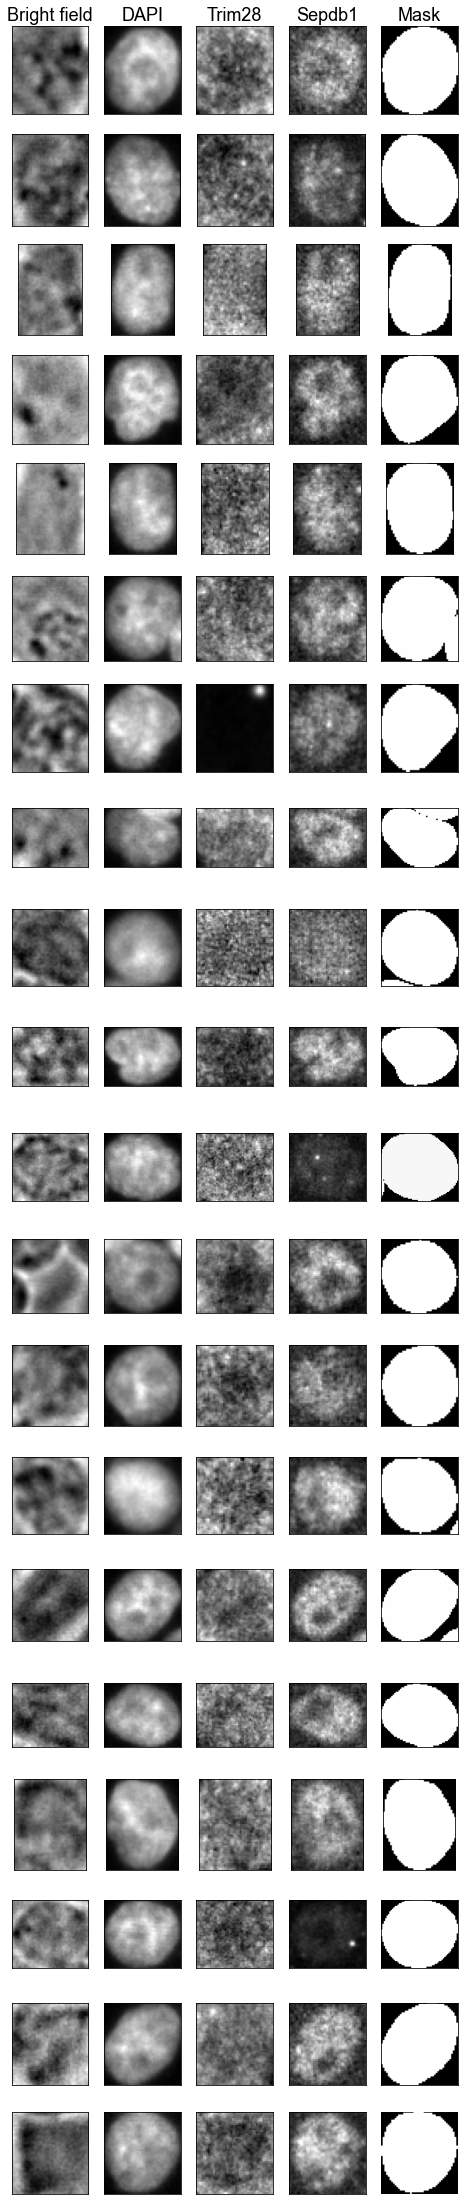

In [20]:
n_sample = 20
not_transfected_sample = props[[not i for i in props.transfected.values]].sample(n=n_sample) 

fig,ax=plt.subplots(n_sample,len(channels)+1,figsize=(8,2*n_sample))

i=0
for idx, cell in not_transfected_sample.iterrows():
    cell_img = X[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3']),:]
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    for j in range(len(channels)):
        ax[i,j].imshow(cell_img[:,:,j], cmap='gray')#,clim=(0,5000))
    ax[i,-1].imshow(cell_mask, cmap='gray')
    i+=1

for j in range(len(channels)):
    ax[0,j].set_title(channels[j])
    plt.axis('off')
ax[0,-1].set_title('Mask')

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_exampleImages.png'),dpi=300)

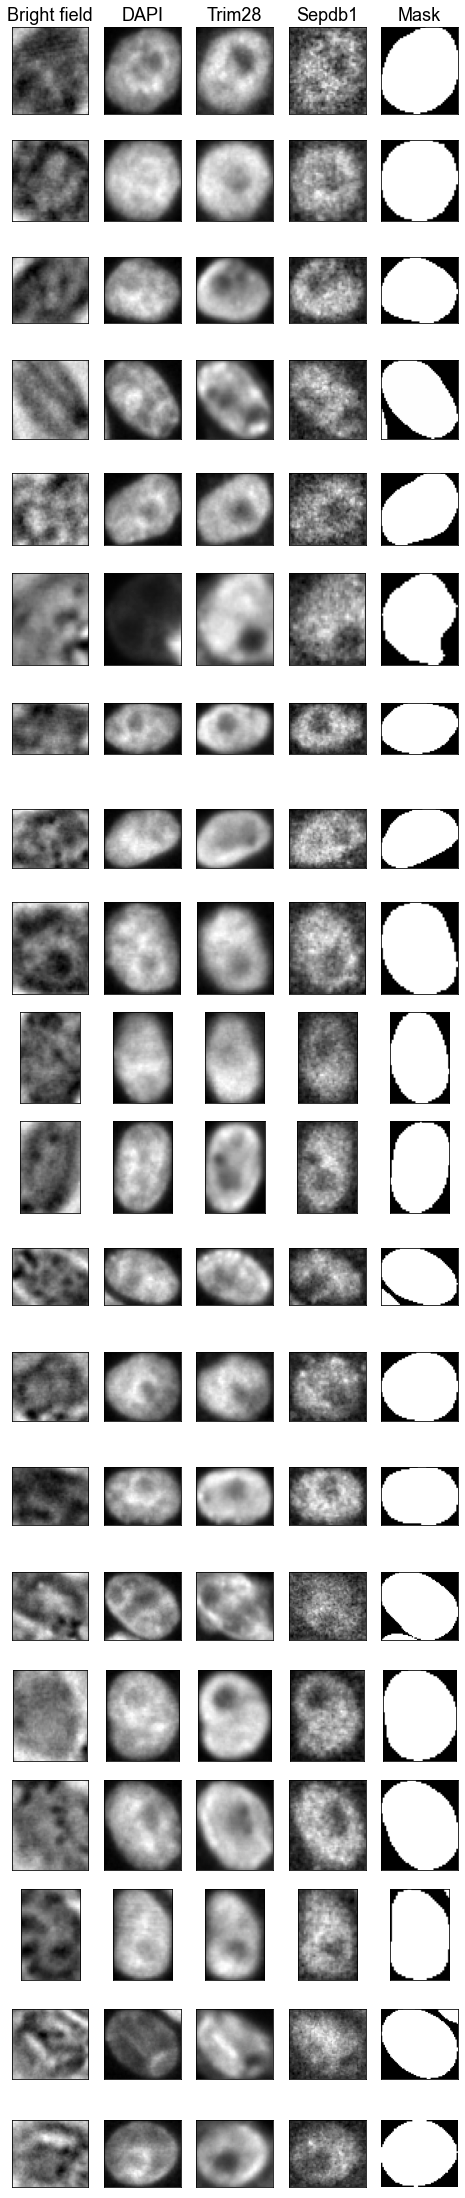

In [13]:
n_sample = 20
transfected_sample = transfected.sample(n=n_sample) 

fig,ax=plt.subplots(n_sample,len(channels)+1,figsize=(8,2*n_sample))

i=0
for idx, cell in transfected_sample.iterrows():
    cell_img = X[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3']),:]
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    for j in range(len(channels)):
        ax[i,j].imshow(cell_img[:,:,j], cmap='gray')#,clim=(0,5000))
    ax[i,-1].imshow(cell_mask, cmap='gray')
    i+=1

for j in range(len(channels)):
    ax[0,j].set_title(channels[j])
    plt.axis('off')
ax[0,-1].set_title('Mask')

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_exampleImages.png'),dpi=300)

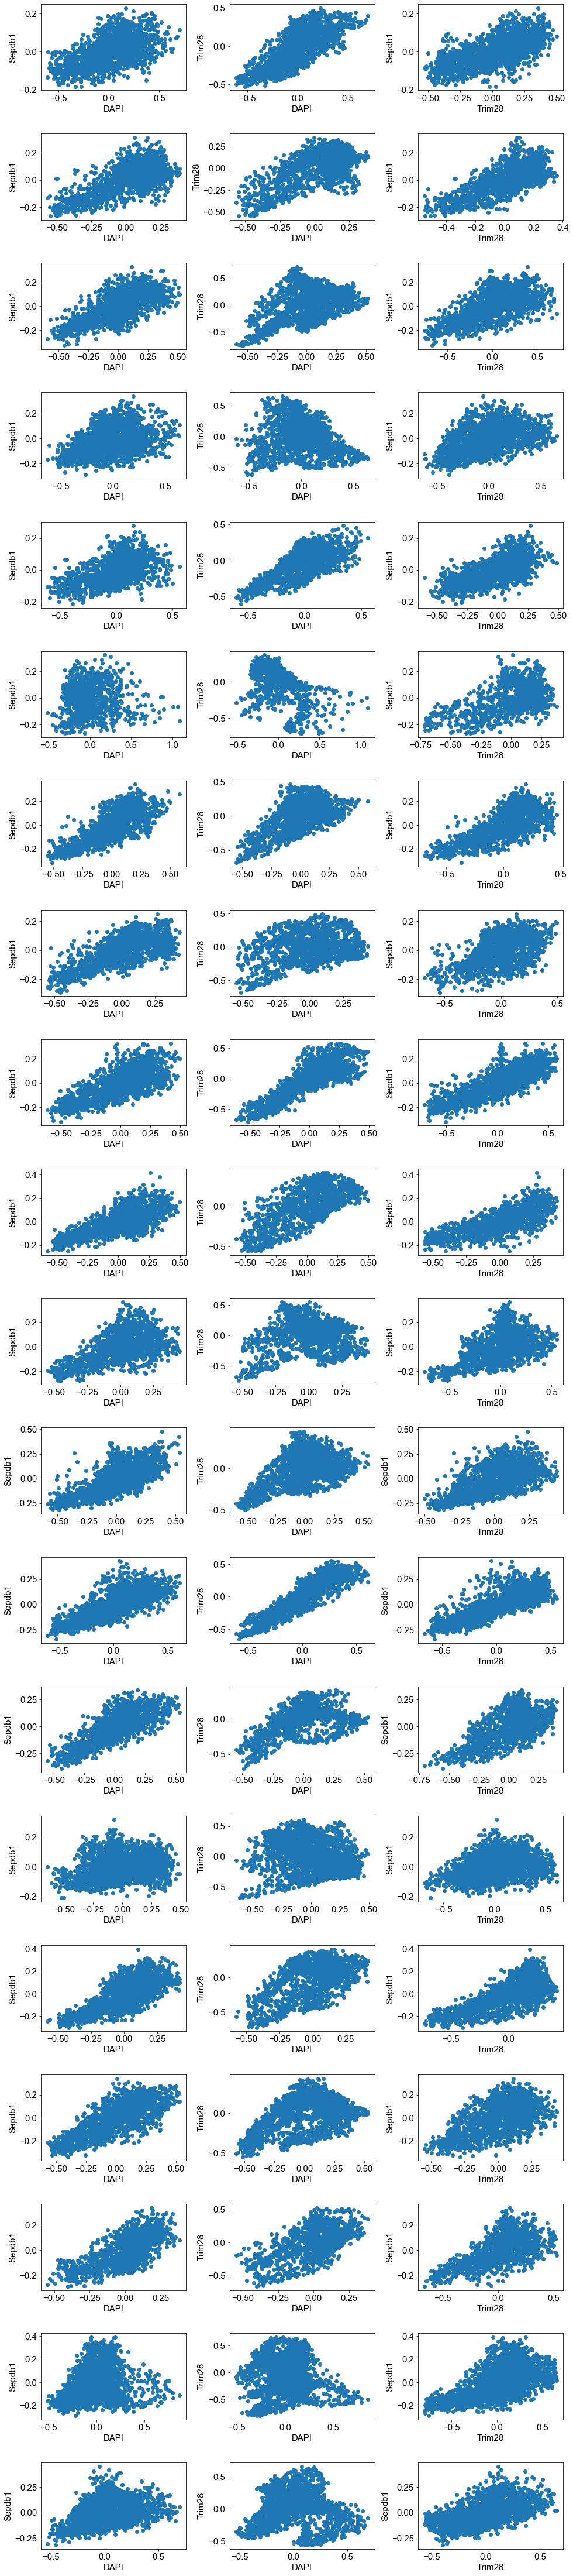

In [21]:
# for the sample, show correlation plots
fig,ax=plt.subplots(n_sample,3,figsize=(16,4*n_sample))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

i=0
for idx, cell in transfected_sample.iterrows():
    cell_img = X[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3']),:]
    cell_img = np.moveaxis(cell_img, -1, 0)
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    
    dapi = cell_img[1].flatten()
    dapi = dapi[cell_mask.flatten()==cell.label]
    dapi = (dapi-np.mean(dapi))/np.mean(dapi)
    
    trim28 = cell_img[2].flatten()
    trim28 = trim28[cell_mask.flatten()==cell.label]
    trim28 = (trim28-np.mean(trim28))/np.mean(trim28)
    
    sepdb1 = cell_img[3].flatten()
    sepdb1 = sepdb1[cell_mask.flatten()==cell.label]
    sepdb1 = (sepdb1-np.mean(sepdb1))/np.mean(sepdb1)
    
    ax[i,0].scatter(dapi,sepdb1)
    ax[i,0].set_xlabel('DAPI')
    ax[i,0].set_ylabel('Sepdb1')

    ax[i,1].scatter(dapi,trim28)
    ax[i,1].set_xlabel('DAPI')
    ax[i,1].set_ylabel('Trim28')

    ax[i,2].scatter(trim28,sepdb1)
    ax[i,2].set_xlabel('Trim28')
    ax[i,2].set_ylabel('Sepdb1')
    
    i+=1


plt.show()


In [22]:
corr_12 = [np.nan for i in range(len(props))] # dapi-trim28
corr_13 = [np.nan for i in range(len(props))] # dapi-sepdb1
corr_23 = [np.nan for i in range(len(props))] # trim28-sepdb1

i=0
for idx, cell in tqdm.tqdm(props.iterrows()):
    cell_img = X[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3']),:]
    cell_img = np.moveaxis(cell_img, -1, 0)
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]

    dapi = cell_img[1].flatten()
    dapi = dapi[cell_mask.flatten()==cell.label]
    dapi = (dapi-np.mean(dapi))/np.mean(dapi)
    
    trim28 = cell_img[2].flatten()
    trim28 = trim28[cell_mask.flatten()==cell.label]
    trim28 = (trim28-np.mean(trim28))/np.mean(trim28)
    
    sepdb1 = cell_img[3].flatten()
    sepdb1 = sepdb1[cell_mask.flatten()==cell.label]
    sepdb1 = (sepdb1-np.mean(sepdb1))/np.mean(sepdb1)

    corr_12[i] = np.corrcoef(dapi,trim28)[0,1]
    corr_13[i] = np.corrcoef(dapi,sepdb1)[0,1]
    corr_23[i] = np.corrcoef(trim28,sepdb1)[0,1]
        
    i+=1

# append data to dataframe
props['corr_12'] = corr_12
props['corr_13'] = corr_13
props['corr_23'] = corr_23
    

15257it [00:30, 600.17it/s]C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
27037it [00:50, 540.54it/s]


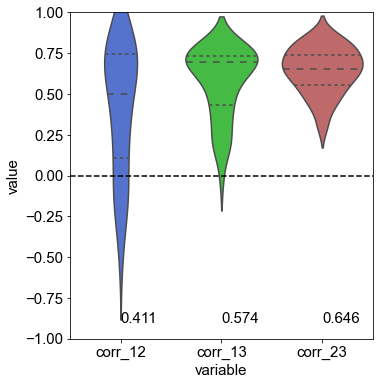

DAPI-Trim28: 0.41063162734477915 0.387965167999633
DAPI-Spedb1: 0.5738310095385313 0.21140218193498958
Trim28-Sepdb1: 0.6458058897671323 0.13931686350178954


In [23]:
# for the sample, show correlation plots
import seaborn as sns
df = props[props.transfected]
df = df[['corr_12','corr_13','corr_23']]

fig,ax=plt.subplots(figsize=(6,6))
fig.subplots_adjust(left=0.2,hspace=0.5,wspace=0.3)

sns.violinplot(x="variable", y="value", data=pd.melt(df), ax=ax, palette=['royalblue','limegreen','indianred'], inner='quartile')#, showfliers=False)

# sns.boxplot(x="variable", y="value", data=pd.melt(df), ax=ax, showfliers=False, palette=['royalblue','limegreen','indianred'])
# sns.swarmplot(x="variable", y="value", data=pd.melt(df), ax=ax, s=1, color='black')

ax.set_ylim(-1,1)
ax.plot([-0.5,2.5],[0,0],'--k')
ax.set_xlim(-0.5,2.5)

ax.text(0,-0.9,'%.3f'%np.mean(df['corr_12']))
ax.text(1,-0.9,'%.3f'%np.mean(df['corr_13']))
ax.text(2,-0.9,'%.3f'%np.mean(df['corr_23']))
plt.show()

print('DAPI-Trim28:', np.mean(df['corr_12']), np.std(df['corr_12']))
print('DAPI-Spedb1:', np.mean(df['corr_13']), np.std(df['corr_13']))
print('Trim28-Sepdb1:', np.mean(df['corr_23']), np.std(df['corr_23']))

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_corrTransfected.png'),dpi=300)

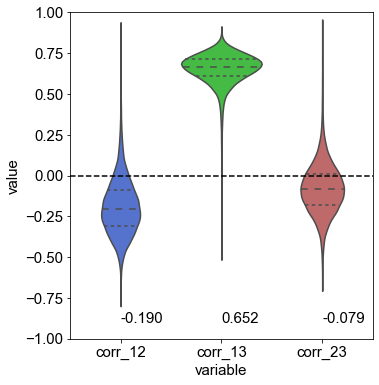

DAPI-Trim28: -0.1904165476671759 0.17265947406457793
DAPI-Spedb1: 0.6518553560239523 0.10832548753606884
Trim28-Sepdb1: -0.07919884769900502 0.1557291888726525


In [24]:
# for the sample, show correlation plots
import seaborn as sns
df = props[props.transfected==False]
df = df[['corr_12','corr_13','corr_23']]

fig,ax=plt.subplots(figsize=(6,6))
fig.subplots_adjust(left=0.2,hspace=0.5,wspace=0.3)

sns.violinplot(x="variable", y="value", data=pd.melt(df), ax=ax, palette=['royalblue','limegreen','indianred'], inner='quartile')#, showfliers=False)
# sns.boxplot(x="variable", y="value", data=pd.melt(df), ax=ax, showfliers=False, palette=['royalblue','limegreen','indianred'])
# sns.swarmplot(x="variable", y="value", data=pd.melt(df), ax=ax, s=2, color='black')

ax.set_ylim(-1,1)
ax.plot([-0.5,2.5],[0,0],'--k')
ax.set_xlim(-0.5,2.5)

ax.text(0,-0.9,'%.3f'%np.mean(df['corr_12']))
ax.text(1,-0.9,'%.3f'%np.mean(df['corr_13']))
ax.text(2,-0.9,'%.3f'%np.mean(df['corr_23']))
plt.show()

print('DAPI-Trim28:', np.mean(df['corr_12']), np.std(df['corr_12']))
print('DAPI-Spedb1:', np.mean(df['corr_13']), np.std(df['corr_13']))
print('Trim28-Sepdb1:', np.mean(df['corr_23']), np.std(df['corr_23']))

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_corrNotTransfected.png'),dpi=300)

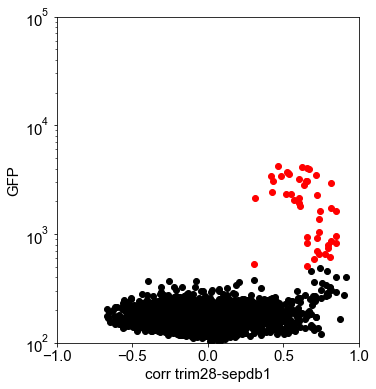

In [25]:

fig,ax=plt.subplots(figsize=(6,6))
fig.subplots_adjust(left=0.2,hspace=0.5,wspace=0.3)

not_trasnfected = props[props.transfected==False]
ax.scatter(not_trasnfected['corr_23'],not_trasnfected['mean_intensity-2'],color='black')
transfected = props[props.transfected==True]
ax.scatter(transfected['corr_23'],transfected['mean_intensity-2'],color='red')
ax.set_xlabel('corr trim28-sepdb1')
ax.set_ylabel('GFP')
ax.set_yscale('log')
ax.set_xlim(-1,1)
ax.set_ylim(1e2, 1e5)

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_corrVsGFP.png'),dpi=300)

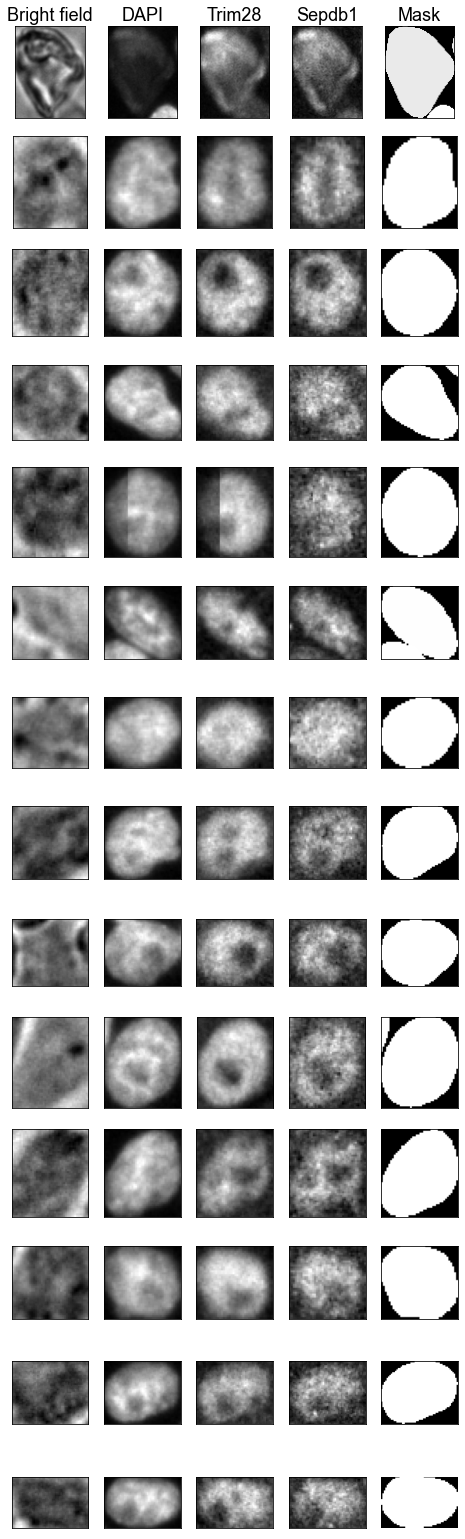

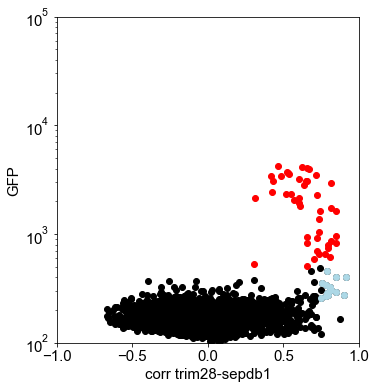

In [46]:
n_sample = 20
hc = props[props.transfected==False]
hc = hc[(hc.corr_23>0.75)&(hc['mean_intensity-2']>200)]#.sample(n=n_sample) 

fig,ax=plt.subplots(np.max([len(hc),2]),len(channels)+1,figsize=(8,2*np.max([len(hc),2])))

i=0
for idx, cell in hc.iterrows():
    cell_img = X[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3']),:]
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    for j in range(len(channels)):
        ax[i,j].imshow(cell_img[:,:,j], cmap='gray')#,clim=(0,5000))
    ax[i,-1].imshow(cell_mask, cmap='gray')
    i+=1

for j in range(len(channels)):
    ax[0,j].set_title(channels[j])
    plt.axis('off')
ax[0,-1].set_title('Mask')

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_exampleImages.png'),dpi=300)


fig,ax=plt.subplots(figsize=(6,6))
fig.subplots_adjust(left=0.2,hspace=0.5,wspace=0.3)

not_trasnfected = props[props.transfected==False]
ax.scatter(not_trasnfected['corr_23'],not_trasnfected['mean_intensity-2'],color='black')
transfected = props[props.transfected==True]
ax.scatter(transfected['corr_23'],transfected['mean_intensity-2'],color='red')
ax.scatter(hc['corr_23'],hc['mean_intensity-2'],color='lightblue')
ax.set_xlabel('corr trim28-sepdb1')
ax.set_ylabel('GFP')
ax.set_yscale('log')
ax.set_xlim(-1,1)
ax.set_ylim(1e2, 1e5)

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_corrVsGFP.png'),dpi=300)